In [1]:
import pandas as pd
from narwhals import DataFrame
from sqlalchemy import create_engine

# 1. 님의 로컬 DB에 접속 (비밀번호 없이 접속 가능하거나, 설정했다면 입력)
# "내 컴퓨터에 있는 냉장고 문을 연다"
db_uri = "postgresql+psycopg2://xodh3@localhost:5432/economy_db"
engine = create_engine(db_uri)
print("✅ DB 연결 성공 및 Pandas 환경 준비 완료")
print("-" * 50)

✅ DB 연결 성공 및 Pandas 환경 준비 완료
--------------------------------------------------


In [2]:
# 1. QQQ 전체 기간 데이터 (Daily) 불러오기 - SQL 쿼리에 ::text 적용!
query_qqq_full = """
SELECT trade_date::text AS trade_date, close_price
FROM market_price_daily
WHERE symbol = 'QQQ'
ORDER BY trade_date ASC;
"""
df_qqq = pd.read_sql(query_qqq_full, engine)

# Datetime 형식으로 변환 및 인덱스 설정 (Resample을 위한 필수 단계)
df_qqq['trade_date'] = pd.to_datetime(df_qqq['trade_date'], utc=True)
df_qqq = df_qqq.set_index('trade_date') # 인덱스 설정

# 2. Resample을 사용하여 월말 종가만 추출합니다.
# 'M' (Month) 주기와 'last()' (마지막 값) 사용
df_qqq_monthly = df_qqq.resample('ME').last()

print("🗓️ QQQ 월별 데이터 (월말 종가만 추출) 완료:")
print(df_qqq_monthly.tail(5))
print("-" * 50)

🗓️ QQQ 월별 데이터 (월말 종가만 추출) 완료:
                           close_price
trade_date                            
2025-08-31 00:00:00+00:00       570.40
2025-09-30 00:00:00+00:00       600.37
2025-10-31 00:00:00+00:00       629.07
2025-11-30 00:00:00+00:00       619.25
2025-12-31 00:00:00+00:00       627.61
--------------------------------------------------


In [3]:
query_unrate = """
SELECT date_time :: text AS trade_date, value AS unemployment_rate
FROM macro_time_series
WHERE indicator_symbol = 'UNRATE'
ORDER BY trade_date DESC;
"""
df_unrate = pd.read_sql(query_unrate, engine)

df_unrate['trade_date'] = pd.to_datetime(df_unrate['trade_date'], utc=True)
df_unrate = df_unrate.set_index('trade_date')

print("📌 UNRATE 월별 데이터 (인덱스 설정) 완료:")
print(df_unrate.tail(5))
print("-" * 50)

📌 UNRATE 월별 데이터 (인덱스 설정) 완료:
                           unemployment_rate
trade_date                                  
1948-03-01 00:00:00+00:00                  4
1948-02-01 00:00:00+00:00                  4
1948-02-01 00:00:00+00:00                  4
1948-01-01 00:00:00+00:00                  3
1948-01-01 00:00:00+00:00                  3
--------------------------------------------------


In [4]:
# 1. 두 데이터의 인덱스(날짜)를 '년-월' 형태로 통일합니다.
# 예: 2025-01-31 -> 2025-01, 2025-01-01 -> 2025-01
df_qqq_monthly.index = df_qqq_monthly.index.to_period('M')
df_unrate.index = df_unrate.index.to_period('M')

print("📅 인덱스 변환 확인 (QQQ):")
print(df_qqq_monthly.index[:3])  # 결과가 'Freq=M'으로 나오면 성공!
print("-" * 30)


# 2. 이제 다시 합칩니다! (Merge)
df_final_monthly = pd.merge(df_qqq_monthly, df_unrate,
                             left_index=True, right_index=True,
                             how='inner')

print("🔗 최종 월별 데이터셋 (QQQ + UNRATE) 합치기 성공:")
print(df_final_monthly.tail(10))

📅 인덱스 변환 확인 (QQQ):
PeriodIndex(['2005-09', '2005-10', '2005-11'], dtype='period[M]', name='trade_date')
------------------------------
🔗 최종 월별 데이터셋 (QQQ + UNRATE) 합치기 성공:
            close_price  unemployment_rate
trade_date                                
2025-04      474.941940                  4
2025-04      474.941940                  4
2025-05      518.533473                  4
2025-05      518.533473                  4
2025-06      551.640000                  4
2025-06      551.640000                  4
2025-07      565.010000                  4
2025-07      565.010000                  4
2025-08      570.400000                  4
2025-08      570.400000                  4


/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2114/525455625.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_qqq_monthly.index = df_qqq_monthly.index.to_period('M')
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2114/525455625.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_unrate.index = df_unrate.index.to_period('M')


In [5]:
# QQQ 월별 데이터 (df_qqq_monthly)와 UNRATE 월별 데이터를 합칩니다.
# left_index=True, right_index=True: 인덱스(날짜)를 기준으로 합치라는 명령어입니다.
df_final_monthly = pd.merge(df_qqq_monthly, df_unrate,
                             left_index=True, right_index=True,
                             how='inner') # inner: 양쪽에 모두 존재하는 월만 남깁니다.

print("🔗 최종 월별 데이터셋 (QQQ + UNRATE) 합치기 완료:")
print(df_final_monthly.tail(100))

🔗 최종 월별 데이터셋 (QQQ + UNRATE) 합치기 완료:
            close_price  unemployment_rate
trade_date                                
2021-07      355.534758                  5
2021-07      355.534758                  5
2021-08      370.533591                  5
2021-08      370.533591                  5
2021-09      349.483684                  5
...                 ...                ...
2025-06      551.640000                  4
2025-07      565.010000                  4
2025-07      565.010000                  4
2025-08      570.400000                  4
2025-08      570.400000                  4

[100 rows x 2 columns]


In [7]:
df_unrate = df_unrate[~df_unrate.index.duplicated(keep= 'first')]

print(f"🧹 중복 제거 완료! 남은 실업률 데이터 개수: {len(df_unrate)}개")

df_final_monthly = pd.merge(df_qqq_monthly, df_unrate, left_index=True, right_index=True, how='inner')

print("-" * 50)
print("🔗 진짜_최종_완성본.csv (월별 데이터):")
print(df_final_monthly.tail(10))


🧹 중복 제거 완료! 남은 실업률 데이터 개수: 932개
--------------------------------------------------
🔗 진짜_최종_완성본.csv (월별 데이터):
            close_price  unemployment_rate
trade_date                                
2024-11      507.621927                  4
2024-12      509.918423                  4
2025-01      520.950049                  4
2025-02      506.866274                  4
2025-03      468.399215                  4
2025-04      474.941940                  4
2025-05      518.533473                  4
2025-06      551.640000                  4
2025-07      565.010000                  4
2025-08      570.400000                  4


In [8]:
# 3. 월별 데이터로 상관계수 구하기
corr = df_final_monthly['close_price'].corr(df_final_monthly['unemployment_rate'])

print(f"📊 월별 QQQ와 실업률의 상관계수: {corr:.4f}")

📊 월별 QQQ와 실업률의 상관계수: -0.4648


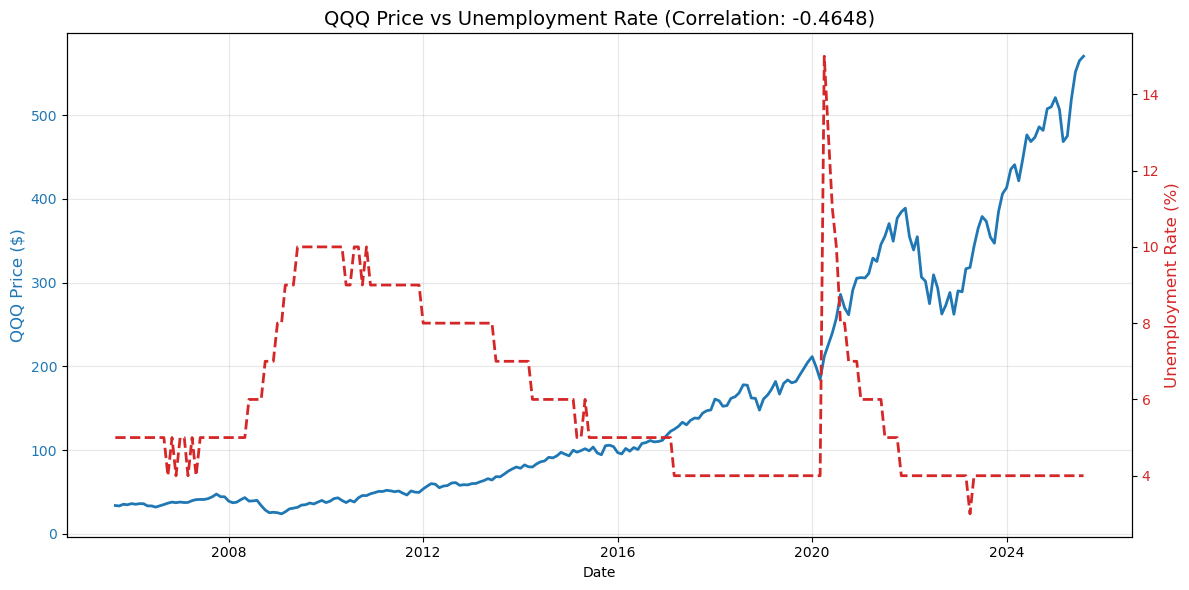

In [11]:
import matplotlib.pyplot as plt

# 1. 그래프용 데이터 준비 (Period -> Timestamp 변환)
# 그래프를 그릴 때는 기간(Period)보다 구체적인 날짜(Timestamp)가 좋습니다.
plot_data = df_final_monthly.copy()
plot_data.index = plot_data.index.to_timestamp()

# 2. 이중 축 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

# 왼쪽 축: QQQ (파란색)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('QQQ Price ($)', color=color, fontsize=12)
ax1.plot(plot_data.index, plot_data['close_price'], color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# 오른쪽 축: 실업률 (빨간색)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Unemployment Rate (%)', color=color, fontsize=12)
ax2.plot(plot_data.index, plot_data['unemployment_rate'], color=color, linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# 제목에 상관계수 포함
plt.title(f"QQQ Price vs Unemployment Rate (Correlation: {corr:.4f})", fontsize=14)
fig.tight_layout()
plt.show()


🔄 이동 상관계수 (최근 5개):
trade_date
2025-04    NaN
2025-05    inf
2025-06    NaN
2025-07    NaN
2025-08    NaN
Freq: M, dtype: float64


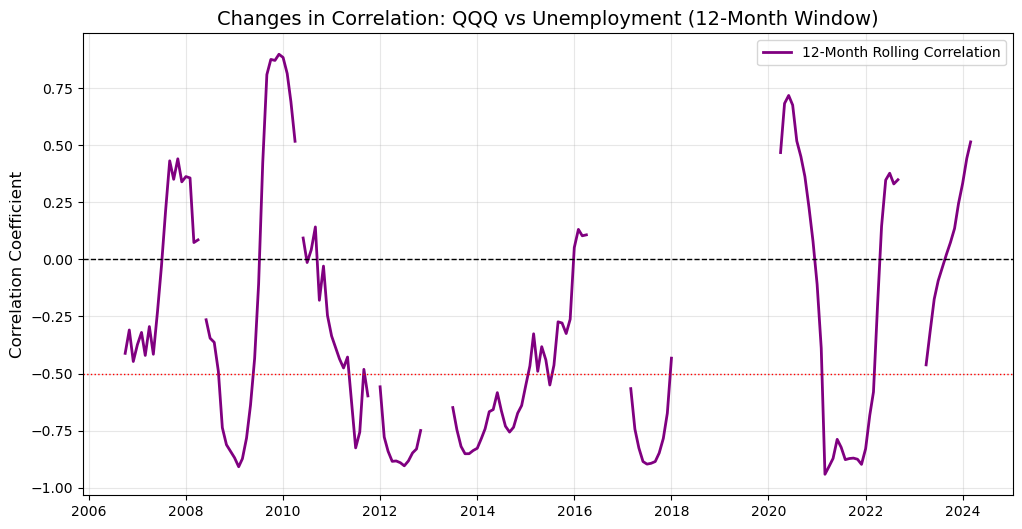

In [12]:
import matplotlib.pyplot as plt

# 1. 이동 상관계수 계산 (핵심 기술! ⚡️)
# window=12: "최근 12개월(1년) 데이터만 봐라"
# corr(...): 그 안에서 상관계수를 구해라
rolling_corr = df_final_monthly['close_price'].rolling(window=12).corr(df_final_monthly['unemployment_rate'])

# 결과 데이터 확인 (처음 11개는 NaN이 나옵니다. 왜냐하면 12개월치가 모여야 계산하니까요!)
print("🔄 이동 상관계수 (최근 5개):")
print(rolling_corr.tail())


# 2. 그래프로 변화 추적하기 (시각화)
# PeriodIndex(2025-01)를 Timestamp로 변환해야 그래프가 잘 그려집니다.
plot_index = rolling_corr.index.to_timestamp()

fig, ax = plt.subplots(figsize=(12, 6))

# 상관계수 선 그리기
ax.plot(plot_index, rolling_corr, color='purple', linewidth=2, label='12-Month Rolling Correlation')

# 기준선 그리기 (0점: 관계 없음 / -1점: 반대 / 1점: 정비례)
ax.axhline(0, color='black', linestyle='--', linewidth=1) # 0점 기준선
ax.axhline(-0.5, color='red', linestyle=':', linewidth=1) # -0.5 (뚜렷한 음의 상관관계)

ax.set_title('Changes in Correlation: QQQ vs Unemployment (12-Month Window)', fontsize=14)
ax.set_ylabel('Correlation Coefficient', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

In [13]:
# 최근 15개월치 실업률 데이터만 봅니다.
print("🔍 최근 실업률 데이터 변화 확인:")
print(df_final_monthly['unemployment_rate'].tail(15))

🔍 최근 실업률 데이터 변화 확인:
trade_date
2024-06    4
2024-07    4
2024-08    4
2024-09    4
2024-10    4
2024-11    4
2024-12    4
2025-01    4
2025-02    4
2025-03    4
2025-04    4
2025-05    4
2025-06    4
2025-07    4
2025-08    4
Freq: M, Name: unemployment_rate, dtype: int64


📉 유효한 상관계수 데이터 개수: 157개


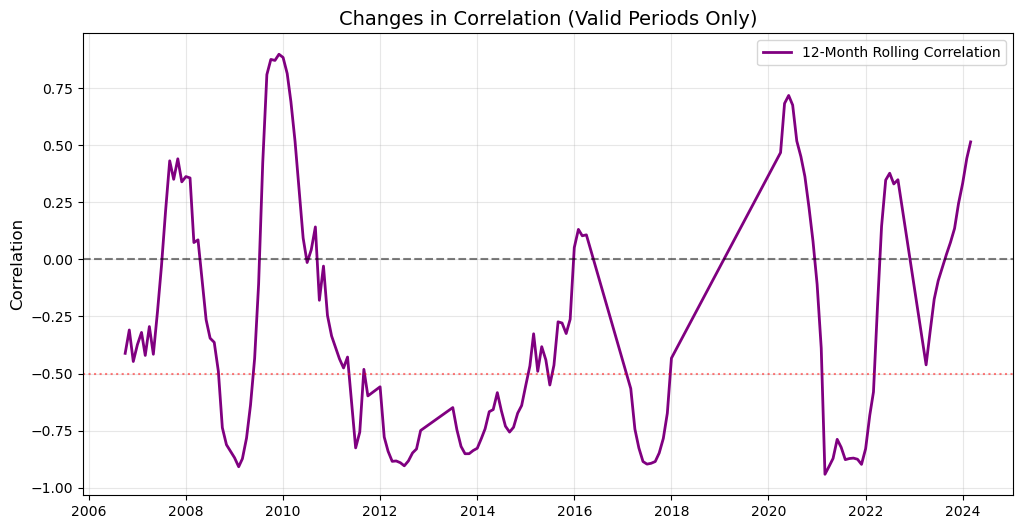

In [14]:
import numpy as np # inf 처리를 위해 필요

# 1. 이동 상관계수 다시 계산
rolling_corr = df_final_monthly['close_price'].rolling(window=12).corr(df_final_monthly['unemployment_rate'])

# 2. 무한대(inf)를 NaN으로 바꾸고, NaN을 제거합니다. (그래프 깨짐 방지)
rolling_corr = rolling_corr.replace([np.inf, -np.inf], np.nan).dropna()

print(f"📉 유효한 상관계수 데이터 개수: {len(rolling_corr)}개")

# 3. 그래프 그리기
if len(rolling_corr) > 0:
    plot_index = rolling_corr.index.to_timestamp() # 시각화용 날짜 변환

    fig, ax = plt.subplots(figsize=(12, 6))

    # 상관계수 선
    ax.plot(plot_index, rolling_corr, color='purple', linewidth=2, label='12-Month Rolling Correlation')

    # 기준선
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.axhline(-0.5, color='red', linestyle=':', alpha=0.5)

    ax.set_title('Changes in Correlation (Valid Periods Only)', fontsize=14)
    ax.set_ylabel('Correlation', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.show()
else:
    print("❌ 그래프를 그릴 수 있는 유효한 데이터가 없습니다. (데이터가 너무 짧거나 변화가 없습니다)")

In [15]:
df_final_monthly['unrate_lag1'] = df_final_monthly['unemployment_rate'].shift(1)

df_final_monthly['unrate_lag2'] = df_final_monthly['unemployment_rate'].shift(3)

df_final_monthly['unrate_lag6'] = df_final_monthly['unemployment_rate'].shift(6)

print("시차데이터 생성 완료")
print(df_final_monthly[['unrate_lag1', 'unrate_lag2', 'unrate_lag6']].head(7))





시차데이터 생성 완료
            unrate_lag1  unrate_lag2  unrate_lag6
trade_date                                       
2005-09             NaN          NaN          NaN
2005-10             5.0          NaN          NaN
2005-11             5.0          NaN          NaN
2005-12             5.0          5.0          NaN
2006-01             5.0          5.0          NaN
2006-02             5.0          5.0          NaN
2006-03             5.0          5.0          5.0


In [16]:
lag_correlation = df_final_monthly[['close_price', 'unemployment_rate', 'unrate_lag1', 'unrate_lag2', 'unrate_lag6']].corr()
print("📊 시차별 상관계수 결과:")
print(lag_correlation['close_price'])

📊 시차별 상관계수 결과:
close_price          1.000000
unemployment_rate   -0.464777
unrate_lag1         -0.455905
unrate_lag2         -0.440547
unrate_lag6         -0.426620
Name: close_price, dtype: float64


In [18]:
# 1. 변화량 데이터 만들기 (Differencing)

# QQQ: 지난달 대비 몇 % 올랐나? (수익률)
df_final_monthly['qqq_return'] = df_final_monthly['close_price'].pct_change()

# 실업률: 지난달 대비 몇 %p 변했나? (단순 차이)
# diff(): (이번 달 값) - (지난 달 값)
df_final_monthly['unrate_change'] = df_final_monthly['unemployment_rate'].diff()

# 2. NaN 제거 (첫 번째 달은 변화량을 구할 수 없으므로)
df_changes = df_final_monthly.dropna()

# 3. 결과 확인: '가격'이 아니라 '변화한 양'이 보일 겁니다.
print("📉 변화량 데이터(Changes) 생성 완료:")
print(df_changes[['qqq_return', 'unrate_change']].tail(5))

📉 변화량 데이터(Changes) 생성 완료:
            qqq_return  unrate_change
trade_date                           
2025-04       0.013968            0.0
2025-05       0.091783            0.0
2025-06       0.063846            0.0
2025-07       0.024237            0.0
2025-08       0.009540            0.0


In [19]:
change_corr = df_changes['qqq_return'].corr(df_changes['unrate_change'])
print(f"📉 변화율(수익률) 기준 상관계수: {change_corr:.4f}")

📉 변화율(수익률) 기준 상관계수: 0.0842


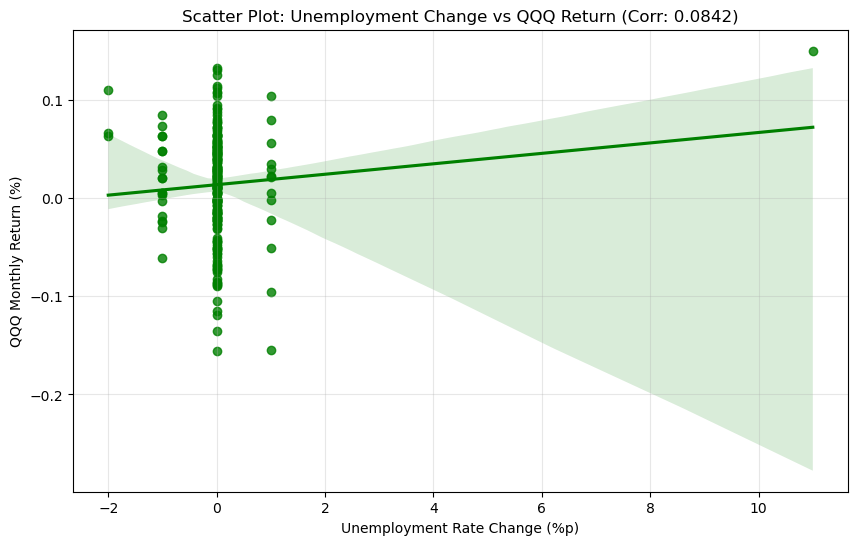

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 산점도 그리기 (Scatter Plot)
# x축: 실업률 변화량 / y축: QQQ 수익률
fig, ax = plt.subplots(figsize=(10, 6))

# regplot: 점(scatter)과 추세선(line)을 같이 그려줍니다.
sns.regplot(x='unrate_change', y='qqq_return', data=df_changes, ax=ax, color='green')

ax.set_title(f'Scatter Plot: Unemployment Change vs QQQ Return (Corr: {change_corr:.4f})')
ax.set_xlabel('Unemployment Rate Change (%p)')
ax.set_ylabel('QQQ Monthly Return (%)')
ax.grid(True, alpha=0.3)

plt.show()

In [24]:
# 1. 기준금리(FEDFUNDS) 데이터 가져오기
# SQL 쿼리에서 ::text 잊지 마세요!
query_fed = """
SELECT date_time::text AS trade_date, value AS fed_rate
FROM macro_time_series
WHERE indicator_symbol = 'FEDFUNDS'
ORDER BY trade_date ASC;
"""
df_fed = pd.read_sql(query_fed, engine)

# 2. 날짜 형식 통일 (Period 변환)
# 이거 안 하면 아까처럼 Empty DataFrame 나옵니다!
df_fed['trade_date'] = pd.to_datetime(df_fed['trade_date'], utc=True)
df_fed = df_fed.set_index('trade_date')
df_fed.index = df_fed.index.to_period('M')

# 3. 기존 데이터(df_final_monthly)에 금리 데이터 합치기
# QQQ + 실업률 + 금리 = 완벽한 거시경제 데이터셋
df_macro = pd.merge(df_final_monthly, df_fed, left_index=True, right_index=True, how='inner')

# 4. 결과 확인
print("💵 3대장(주가, 실업률, 금리) 합체 완료:")
print(df_macro.tail(10))

💵 3대장(주가, 실업률, 금리) 합체 완료:
            close_price  unemployment_rate  unrate_lag1  unrate_lag2  \
trade_date                                                             
2025-04      474.941940                  4          4.0          4.0   
2025-04      474.941940                  4          4.0          4.0   
2025-05      518.533473                  4          4.0          4.0   
2025-05      518.533473                  4          4.0          4.0   
2025-06      551.640000                  4          4.0          4.0   
2025-06      551.640000                  4          4.0          4.0   
2025-07      565.010000                  4          4.0          4.0   
2025-07      565.010000                  4          4.0          4.0   
2025-08      570.400000                  4          4.0          4.0   
2025-08      570.400000                  4          4.0          4.0   

            unrate_lag6  qqq_return  unrate_changes  unrate_change  fed_rate  
trade_date                    

/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2114/3605392580.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_fed.index = df_fed.index.to_period('M')


In [25]:
df_macro = df_macro[~df_macro.index.duplicated(keep='first')]

print(f"🧹 중복 제거 완료! 남은 데이터 개수: {len(df_macro)}개")
print(df_macro[['close_price', 'fed_rate']].tail(5))

🧹 중복 제거 완료! 남은 데이터 개수: 240개
            close_price  fed_rate
trade_date                       
2025-04      474.941940         4
2025-05      518.533473         4
2025-06      551.640000         4
2025-07      565.010000         4
2025-08      570.400000         4


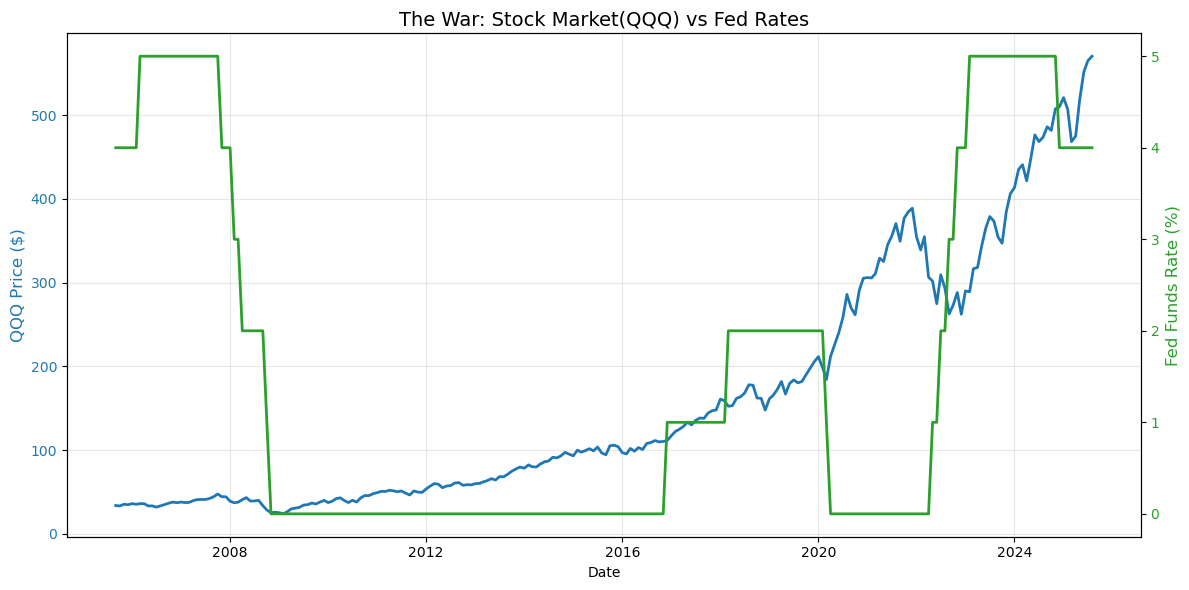

In [27]:
import matplotlib.pyplot as plt

# 1. 그래프용 데이터 준비 (Period -> Timestamp 변환)
plot_data = df_macro.copy()
plot_data.index = plot_data.index.to_timestamp()

# 2. 이중 축 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

# 왼쪽 축: QQQ (파란색)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('QQQ Price ($)', color=color, fontsize=12)
ax1.plot(plot_data.index, plot_data['close_price'], color=color, linewidth=2, label='QQQ Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# 오른쪽 축: 기준금리 (초록색 - 돈의 가격)
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Fed Funds Rate (%)', color=color, fontsize=12)
ax2.plot(plot_data.index, plot_data['fed_rate'], color=color, linewidth=2, linestyle='-', label='Fed Rate')
ax2.tick_params(axis='y', labelcolor=color)

# 제목 설정
plt.title("The War: Stock Market(QQQ) vs Fed Rates", fontsize=14)
fig.tight_layout()
plt.show()